In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
attrs_scaled = np.load("attrs.npy")

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

**Кросс-валидация финальной модели глубокого автоэнкодера**

In [ ]:
def deep_ae(dim1, dim2, weigts_init, bias_init):
    encoding_dim = 10 # судя по дисперсиям 90% инфы дают 10 компонент (см. PCA)
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_attrs)
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    code = Dense(encoding_dim, activation='linear')(x)
    
    input_code = Input(shape = (encoding_dim,))
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_code)
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    out_attrs = Dense(20, activation='linear')(x)

    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    return autoencoder

In [ ]:
# гиперпараметры
DIM_1L = 19
DIM_2L = 17
WEIGTHS_INIT = 'random_uniform'
BIAS_INIT = 'zeros'
LERN_RATE = 0.0005
LOSS = 'mse'
OPTI = globals()['Adam']
BATCH = 70

In [ ]:
epo = 1000
hists = []
folds = 10

kf = KFold(n_splits = folds, shuffle = True)

num_fold = 1
for train, test in kf.split(attrs_scaled, attrs_scaled):

  d_ae = deep_ae(DIM_1L, DIM_2L, WEIGTHS_INIT, BIAS_INIT)

  d_ae.compile(OPTI(LERN_RATE), loss=LOSS, metrics=['mae'])

  print("Number of fold {} ======================================================".format(num_fold))

  hist = d_ae.fit(attrs_scaled[train], # shape[0] у подаваемых объектов должен быть их числом
                  attrs_scaled[train], 
                  epochs=epo, # в конце каждой эпохи проводится мониторинг функции потерь (val_loss) на validation_data (эпоха - отработать все объекты (случайно выбирается в течение эпохи количество объектов = количеству объектов в тренировочной выборке))
                  batch_size=BATCH, # сколько объектов будет накоплено (в сумму функционала ошибки) для одного обновления градиента (по умолчанию 32)
                  shuffle=True, # перемешивать ли тренировочные данные в конце каждой эпохи
                  verbose=2, # показ progress bar
                  validation_data=(attrs_scaled[test], attrs_scaled[test])) # данные для контроля переобучения
  
  d_ae.save_weights('/content/drive/My Drive/Colab Notebooks/model1_cross_val/d_ae_fold{}.h5'.format(num_fold))

  hists.append(hist)
  num_fold += 1

Fold 1


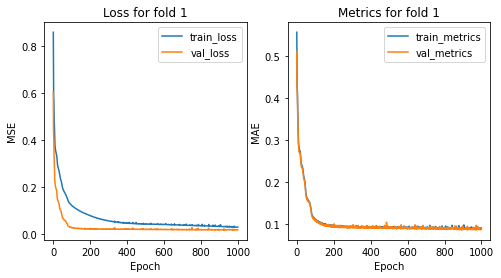

<Figure size 432x288 with 0 Axes>

Fold 2


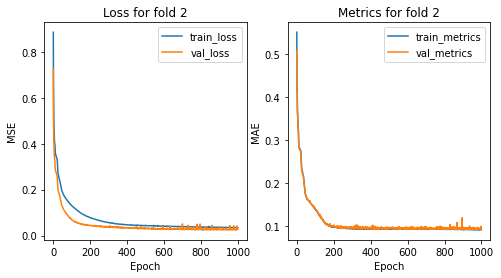

<Figure size 432x288 with 0 Axes>

Fold 3


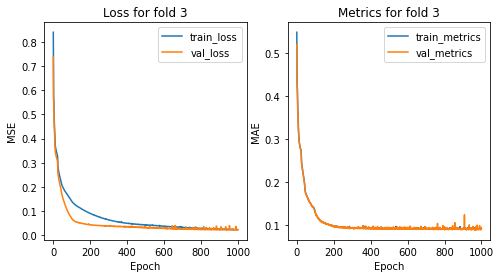

<Figure size 432x288 with 0 Axes>

Fold 4


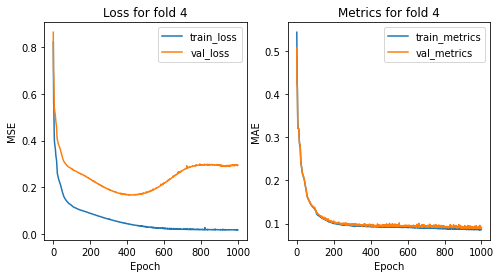

<Figure size 432x288 with 0 Axes>

Fold 5


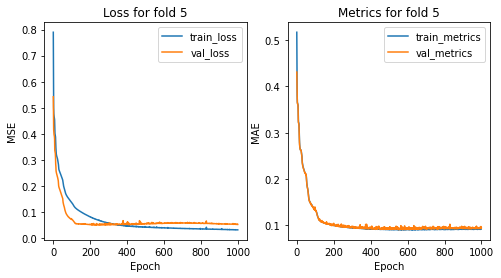

<Figure size 432x288 with 0 Axes>

Fold 6


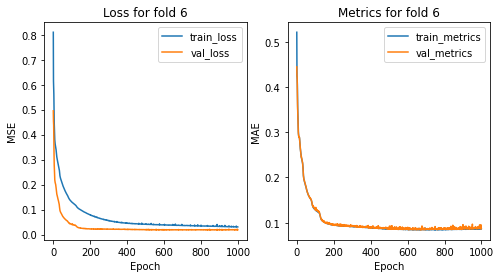

<Figure size 432x288 with 0 Axes>

Fold 7


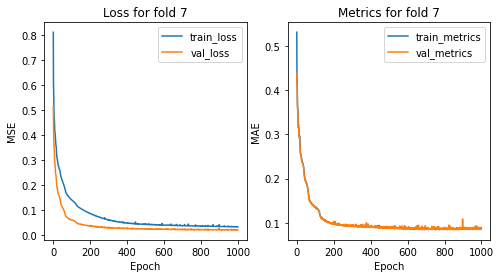

<Figure size 432x288 with 0 Axes>

Fold 8


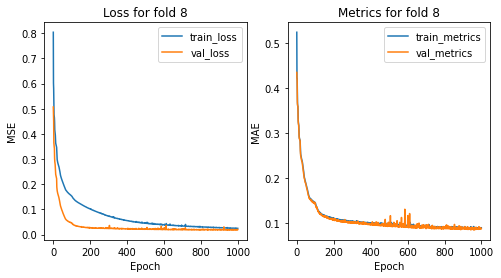

<Figure size 432x288 with 0 Axes>

Fold 9


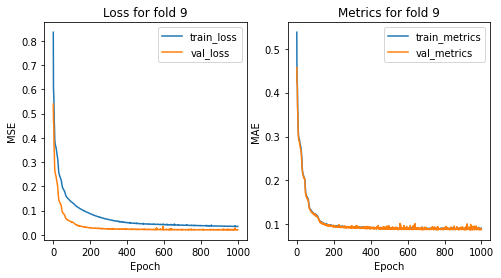

<Figure size 432x288 with 0 Axes>

In [ ]:
N = np.arange(0, epo)
for i in range(1, folds):
  print("Fold {}".format(i))
  
  fig, (ax1, ax2) = plt.subplots(
  nrows=1, ncols=2,
  figsize=(8, 4) )

  ax1.plot(N, hists[i-1].history["loss"], label="train_loss")
  ax1.plot(N, hists[i-1].history["val_loss"], label="val_loss")

  ax1.set_title("Loss for fold {}".format(i))
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("MSE")
  ax1.legend()

  fig = plt.figure()
  ax2.plot(N, hists[i-1].history["mae"], label="train_metrics")
  ax2.plot(N, hists[i-1].history["val_mae"], label="val_metrics")

  ax2.set_title("Metrics for fold {}".format(i))
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MAE")
  ax2.legend()

  plt.show()

**Получение кода финальной модели**

In [ ]:
def deep_ae(dim1, dim2, weigts_init, bias_init):
    encoding_dim = 10 # судя по дисперсиям 90% инфы дают 10 компонент (см. PCA)
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_attrs)
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    code = Dense(encoding_dim, activation='linear')(x)
    
    input_code = Input(shape = (encoding_dim,))
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_code)
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    out_attrs = Dense(20, activation='linear')(x)

    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    return autoencoder

In [ ]:
# гиперпараметры
DIM_1L = 19
DIM_2L = 17
WEIGTHS_INIT = 'random_uniform'
BIAS_INIT = 'zeros'
LERN_RATE = 0.0005
LOSS = 'mse'
OPTI = globals()['Adam']
BATCH = 70

In [ ]:
d_ae = deep_ae(DIM_1L, DIM_2L, WEIGTHS_INIT, BIAS_INIT)
d_ae.compile(OPTI(LERN_RATE), loss=LOSS, metrics=['mae'])

In [ ]:
from keras.models import load_model
d_ae.load_weights("model.h5")

In [ ]:
d_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                919       
_________________________________________________________________
decoder (Model)              (None, 20)                909       
Total params: 1,828
Trainable params: 1,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ex_in = np.array([attrs_scaled[0]])

In [ ]:
ex_in.shape

(1, 20)

In [ ]:
d_ae.predict(ex_in)

array([[-0.42672318, -0.42814028,  0.03245163, -0.30703688,  0.03503335,
        -0.01717222,  0.478937  , -0.76831776, -0.7508707 , -0.727896  ,
        -0.06770939, -0.4078436 , -0.17344236,  0.13446665,  0.07530636,
        -0.00448811, -1.0663242 , -0.4841082 , -0.7301264 , -0.08537298]],
      dtype=float32)

In [ ]:
ex_code = d_ae.get_layer(name="encoder").predict(ex_in)
ex_code

array([[-0.04075626,  0.1118559 , -0.00633518, -0.08706042, -0.07884292,
         0.21149579,  0.17684034,  0.1282975 ,  0.25078997,  0.05392696]],
      dtype=float32)

In [ ]:
attrs_scaled_ = d_ae.predict(attrs_scaled)
attrs_scaled_

array([[-0.4267233 , -0.42814028,  0.03245115, ..., -0.48410797,
        -0.7301259 , -0.08537292],
       [-0.46654052, -0.4626627 ,  4.283911  , ...,  0.1127758 ,
         0.84446836,  0.7088955 ],
       [-0.42592782, -0.43585384,  1.2667174 , ...,  2.3873017 ,
         1.1994822 ,  1.3839512 ],
       ...,
       [-0.48575407, -0.5068244 , -0.45760447, ...,  0.48270512,
         0.26812506,  0.8293107 ],
       [-0.473705  , -0.49567056, -0.5349253 , ...,  0.9456332 ,
         0.11964113,  1.0848773 ],
       [-0.5123027 , -0.5246482 , -0.48063594, ...,  0.19332051,
         0.6798817 ,  0.7512916 ]], dtype=float32)

In [ ]:
code = d_ae.get_layer(name="encoder").predict(attrs_scaled)
code

array([[-0.04075624,  0.11185589, -0.00633518, ...,  0.1282975 ,
         0.25079   ,  0.05392694],
       [-0.09331088,  0.22502705, -0.34418288, ...,  0.05844329,
         0.0082777 , -0.09508671],
       [ 0.03822991, -0.04001793, -0.30775517, ...,  0.19554971,
         0.10009045, -0.14121689],
       ...,
       [ 0.11554973,  0.02361912, -0.08094855, ...,  0.11113176,
         0.3506827 ,  0.01628407],
       [ 0.08017434, -0.02117085, -0.08866491, ...,  0.11186515,
         0.27606553,  0.09862354],
       [ 0.05259812,  0.02972297, -0.03831737, ...,  0.1206663 ,
         0.32645527,  0.02827663]], dtype=float32)

In [ ]:
code.shape

(17080, 10)

**Разреженный** **автоэнкодер**

In [ ]:
from keras.regularizers import L1L2

def create_sparse_ae(lambda_l1=0.00001, dim1, dim2, act, l_rate, ls):
    encoding_dim = 10
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation=act)(input_attrs)
    x = Dense(dim2, activation=act)(x)
    code = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    input_code = Input(shape=(encoding_dim,))
    x = Dense(dim2, activation='relu')(input_code)
    x = Dense(dim1, activation='relu')(x)
    out_attrs = Dense(20, activation='linear')(x)
    
    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    autoencoder.compile(opt(l_rate), loss=ls)
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
s_autoencoder.fit(x_train, x_train,
                epochs=400,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))